In [1]:
# ============================
# 🧩 PART 1 — Hidden Markov Model (HMM)
# ============================

import re, math, random, time
import numpy as np
from collections import defaultdict

# Load words from corpus.txt
def load_words(path='corpus.txt'):
    with open(path, 'r', encoding='utf-8') as f:
        return [re.sub('[^a-z]', '', w.strip().lower()) for w in f if w.strip()]

print("Loading corpus.txt ...")
train_words = load_words('corpus.txt')
print(f"Loaded {len(train_words)} words from corpus.txt")

letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
idx = {c: i for i, c in enumerate(letters)}

# HMM definition (bigram model)
class BigramHMM:
    def __init__(self, words, idx, alpha=1.0):
        self.idx = idx
        self.V = len(idx)
        self.words_by_len = defaultdict(list)
        for w in words:
            self.words_by_len[len(w)].append(w)
        self._train(words, alpha)

    def _train(self, words, alpha=1.0):
        V = self.V
        init = np.ones(V) * alpha
        trans = np.ones((V, V)) * alpha
        for w in words:
            if len(w) == 0: continue
            init[self.idx[w[0]]] += 1
            for a, b in zip(w, w[1:]):
                trans[self.idx[a], self.idx[b]] += 1
        self.init_p = init / init.sum()
        self.trans_p = trans / trans.sum(axis=1, keepdims=True)

    def score(self, w):
        lp = math.log(self.init_p[self.idx[w[0]]])
        for a, b in zip(w, w[1:]):
            lp += math.log(self.trans_p[self.idx[a], self.idx[b]])
        return lp

    def letter_probs_for_pattern(self, pattern, guessed=set()):
        L = len(pattern)
        candidates = self.words_by_len.get(L, [])
        candidates = [w for w in candidates if all(pattern[i] in ('_', w[i]) for i in range(L))]
        if not candidates:
            return np.ones(self.V)/self.V, [np.ones(self.V)/self.V for _ in range(L)]
        lps = np.array([self.score(w) for w in candidates])
        lps = lps - lps.max()
        probs = np.exp(lps); probs /= probs.sum()
        letter_vec = np.zeros(self.V)
        pos_probs = [np.zeros(self.V) for _ in range(L)]
        for w, pw in zip(candidates, probs):
            for i, ch in enumerate(w):
                if pattern[i] == '_':
                    pos_probs[i][self.idx[ch]] += pw
                    letter_vec[self.idx[ch]] += pw
        for g in guessed:
            if g in self.idx:
                letter_vec[self.idx[g]] = 0.0
                for p in pos_probs:
                    p[self.idx[g]] = 0.0
        if letter_vec.sum() > 0:
            letter_vec = letter_vec / letter_vec.sum()
        else:
            letter_vec = np.ones(self.V)/self.V
        pos_probs = [p / p.sum() if p.sum() > 0 else np.ones(self.V)/self.V for p in pos_probs]
        return letter_vec, pos_probs

# Train HMM
hmm = BigramHMM(train_words, idx)
print("✅ Trained Bigram HMM successfully.")

# Demo check
pattern = "_a__"
agg, pos = hmm.letter_probs_for_pattern(pattern)
print("Example pattern =", pattern)
print("Top probable letters:", sorted([(letters[i], float(agg[i])) for i in range(26)], key=lambda x:-x[1])[:8])

# ============================
# 🤖 PART 2 — Reinforcement Learning Agent (DQN)
# ============================

import torch, torch.nn as nn, torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt

# Environment
class HangmanEnv:
    def __init__(self, words, letters, idx, max_wrong=6, hmmer=None):
        self.words, self.letters, self.idx = words, letters, idx
        self.max_wrong = max_wrong
        self.hmm = hmmer
        self.max_len = max(len(w) for w in words)
        # Initialize attributes here as well
        self.word = None
        self.mask = []
        self.guessed = set()
        self.wrong = 0

    def reset(self, word=None):
        self.word = word or random.choice(self.words)
        self.mask = ['_'] * len(self.word)
        self.guessed = set()
        self.wrong = 0
        return self._obs()

    def _obs(self):
        L = self.max_len
        X = np.zeros((L, 26), dtype=np.float32)
        for i, ch in enumerate(self.mask):
            if ch != '_' and ch in self.idx:
                X[i, self.idx[ch]] = 1.0
        guessed = np.zeros(26, dtype=np.float32)
        for g in self.guessed:
            guessed[self.idx[g]] = 1.0
        hmm_vec = np.zeros(26, dtype=np.float32)
        if self.hmm:
            v, _ = self.hmm.letter_probs_for_pattern(''.join(self.mask), self.guessed)
            hmm_vec = v.astype(np.float32)
        return np.concatenate([X.flatten(), guessed, hmm_vec])

    def step(self, action_idx):
        letter = self.letters[action_idx]
        reward = 0.0
        info = {}
        if letter in self.guessed:
            self.wrong += 1
            reward -= 0.2
            info['repeat'] = True
        else:
            self.guessed.add(letter)
            if letter in self.word:
                for i, c in enumerate(self.word):
                    if c == letter:
                        self.mask[i] = letter
                reward += 0.25
            else:
                self.wrong += 1
                reward -= 1.0
        done = False
        if '_' not in self.mask:
            done = True
            reward += 2.0
            info['success'] = True
        elif self.wrong >= self.max_wrong:
            done = True
            reward -= 0.5
            info['success'] = False
        return self._obs(), reward, done, info


# DQN components
Transition = namedtuple('Transition', ('s', 'a', 'r', 'ns', 'd', 'mask'))

class Replay:
    def __init__(self, cap=100000): self.buf = deque(maxlen=cap)
    def push(self, *args): self.buf.append(Transition(*args))
    def sample(self, n): batch = random.sample(self.buf, n); return Transition(*zip(*batch))
    def __len__(self): return len(self.buf)

class QNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, out_dim)
        )
    def forward(self, x): return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-4):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.online = QNet(state_dim, action_dim).to(self.device)
        self.target = QNet(state_dim, action_dim).to(self.device)
        self.target.load_state_dict(self.online.state_dict())
        self.opt = optim.Adam(self.online.parameters(), lr=lr)
        self.replay = Replay()
        self.batch_size = 64
        self.gamma = 0.99
        self.train_steps = 0

    def select_action(self, state, avail_mask, eps):
        if random.random() < eps:
            ids = np.where(avail_mask == 1)[0]
            return int(np.random.choice(ids))
        s = torch.tensor(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            q = self.online(s).cpu().numpy().squeeze()
        q = q - (1 - avail_mask) * 1e6
        return int(np.argmax(q))

    def train_step(self):
        if len(self.replay) < 1000:
            return None
        batch = self.replay.sample(self.batch_size)
        s = torch.tensor(np.stack(batch.s)).float().to(self.device)
        a = torch.tensor(batch.a).long().unsqueeze(1).to(self.device)
        r = torch.tensor(batch.r).float().unsqueeze(1).to(self.device)
        ns = torch.tensor(np.stack(batch.ns)).float().to(self.device)
        d = torch.tensor(batch.d).float().unsqueeze(1).to(self.device)
        mask = torch.tensor(np.stack(batch.mask)).float().to(self.device)
        qvals = self.online(s).gather(1, a)
        with torch.no_grad():
            qnext = self.target(ns)
            qnext = qnext - (1 - mask) * 1e6
            qmax = qnext.max(1, keepdim=True)[0]
            target = r + (1 - d) * self.gamma * qmax
        loss = nn.functional.mse_loss(qvals, target)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        self.train_steps += 1
        if self.train_steps % 1000 == 0:
            self.target.load_state_dict(self.online.state_dict())
        return loss.item()


# Training loop
def train_agent(episodes=2000, max_wrong=6, hmm_thresh=0.7, curriculum=True):
    env = HangmanEnv(train_words, letters, idx, max_wrong=max_wrong, hmmer=hmm)
    state_dim = env._obs().shape[0]
    agent = DQNAgent(state_dim, 26)

    eps = 1.0
    eps_min = 0.05
    eps_decay = (eps - eps_min) / (episodes * 0.6 + 1e-9)

    lengths = np.array([len(w) for w in train_words])
    weights = None
    if curriculum:
        weights = (lengths / lengths.max()) + 0.05
        weights = weights / weights.sum()

    rewards, losses = [], []
    start = time.time()

    for ep in range(1, episodes + 1):
        word = np.random.choice(train_words, p=weights) if weights is not None else random.choice(train_words)
        s = env.reset(word=word)
        done = False; ep_r = 0.0

        while not done:
            pattern = ''.join(env.mask)
            agg, _ = hmm.letter_probs_for_pattern(pattern, env.guessed)
            top_idx = int(np.argmax(agg)); top_p = float(agg[top_idx])
            if top_p >= hmm_thresh and (letters[top_idx] not in env.guessed):
                a = top_idx
            else:
                avail = np.array([1 if l not in env.guessed else 0 for l in letters])
                a = agent.select_action(s, avail, eps)

            ns, rew, done, info = env.step(a)
            next_avail = np.array([1 if l not in env.guessed else 0 for l in letters])
            agent.replay.push(s, a, rew, ns, float(done), next_avail)
            loss = agent.train_step()
            if loss is not None: losses.append(loss)
            s = ns; ep_r += rew

        rewards.append(ep_r)
        eps = max(eps_min, eps - eps_decay)
        if ep % 200 == 0:
            print(f"Ep {ep}/{episodes} avgR={np.mean(rewards[-200:]):.3f} eps={eps:.3f}")

    torch.save(agent.online.state_dict(), "dqn_final.pth")
    print("✅ Training complete. Model saved as dqn_final.pth")
    return agent, rewards, losses, env

Loading corpus.txt ...
Loaded 50000 words from corpus.txt
✅ Trained Bigram HMM successfully.
Example pattern = _a__
Top probable letters: [('t', 0.13899226222295952), ('g', 0.09498791036680168), ('e', 0.09264651636376418), ('l', 0.07288993656614404), ('n', 0.07140597454272626), ('o', 0.06736427459396731), ('r', 0.06061984736110982), ('p', 0.05497918858021536)]


In [2]:
agent, rewards, losses, env = train_agent(episodes=8000, max_wrong=6, hmm_thresh=0.5, curriculum=True)

Ep 200/8000 avgR=-5.362 eps=0.960
Ep 400/8000 avgR=-4.968 eps=0.921
Ep 600/8000 avgR=-5.004 eps=0.881
Ep 800/8000 avgR=-5.161 eps=0.842
Ep 1000/8000 avgR=-5.021 eps=0.802
Ep 1200/8000 avgR=-4.829 eps=0.763
Ep 1400/8000 avgR=-4.781 eps=0.723
Ep 1600/8000 avgR=-4.559 eps=0.683
Ep 1800/8000 avgR=-4.763 eps=0.644
Ep 2000/8000 avgR=-4.625 eps=0.604
Ep 2200/8000 avgR=-4.006 eps=0.565
Ep 2400/8000 avgR=-4.004 eps=0.525
Ep 2600/8000 avgR=-4.032 eps=0.485
Ep 2800/8000 avgR=-3.965 eps=0.446
Ep 3000/8000 avgR=-3.414 eps=0.406
Ep 3200/8000 avgR=-3.565 eps=0.367
Ep 3400/8000 avgR=-3.578 eps=0.327
Ep 3600/8000 avgR=-2.859 eps=0.288
Ep 3800/8000 avgR=-2.790 eps=0.248
Ep 4000/8000 avgR=-2.277 eps=0.208
Ep 4200/8000 avgR=-2.370 eps=0.169
Ep 4400/8000 avgR=-2.105 eps=0.129
Ep 4600/8000 avgR=-2.310 eps=0.090
Ep 4800/8000 avgR=-2.527 eps=0.050
Ep 5000/8000 avgR=-1.551 eps=0.050
Ep 5200/8000 avgR=-1.302 eps=0.050
Ep 5400/8000 avgR=-1.511 eps=0.050
Ep 5600/8000 avgR=-1.367 eps=0.050
Ep 5800/8000 avgR=-1.147


Evaluating trained agent ...
 Success Rate: 53.00%
Avg Wrong Guesses: 4.79
 Avg Repeated Guesses: 0.00


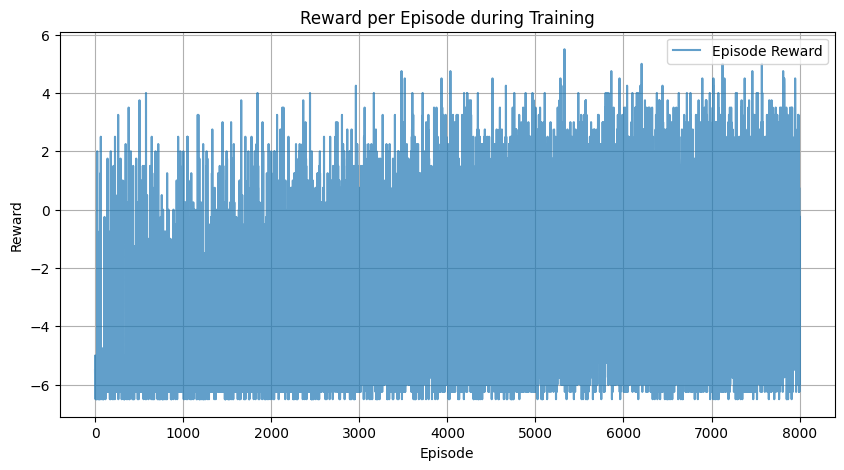

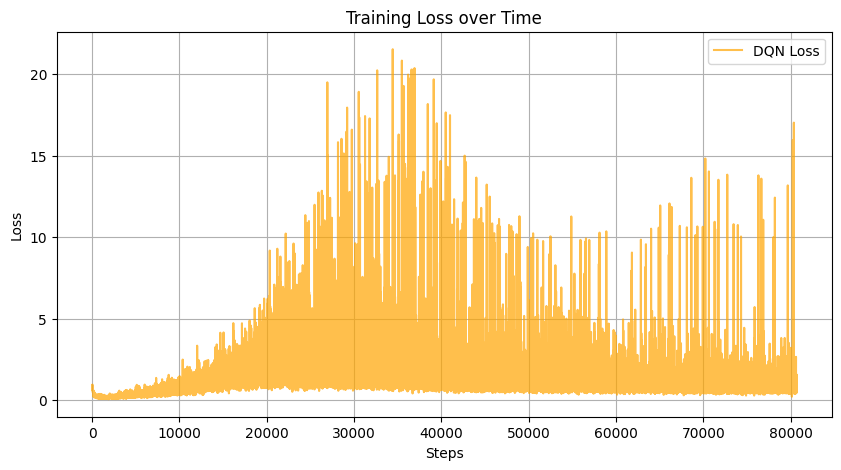


===== FINAL REPORT =====
Final Success Rate: 53.00%
Average Wrong Guesses: 4.79
Average Repeated Guesses: 0.00


In [3]:
# ============================
#  PART 3 — Evaluation & Results
# ============================

import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_agent(agent, env, n_games=200):
    """
    Evaluate the trained DQN agent on unseen words.
    Returns success rate, avg wrong guesses, and avg repeated guesses.
    """
    successes = 0
    total_wrong, total_repeat = 0, 0

    for _ in range(n_games):
        word = random.choice(train_words)
        s = env.reset(word=word)
        done = False
        while not done:
            pattern = ''.join(env.mask)
            agg, _ = hmm.letter_probs_for_pattern(pattern, env.guessed)
            avail = np.array([1 if l not in env.guessed else 0 for l in letters])
            a = agent.select_action(s, avail, eps=0.05)  # mostly exploit
            s, _, done, info = env.step(a)
        if info.get("success"):
            successes += 1
        total_wrong += env.wrong
        total_repeat += len([g for g in env.guessed if env.guessed.count(g) > 1]) if hasattr(env.guessed, "count") else 0

    success_rate = successes / n_games * 100
    avg_wrong = total_wrong / n_games
    avg_repeat = total_repeat / n_games
    return success_rate, avg_wrong, avg_repeat


#  Evaluate your agent (use the env returned from train_agent)
print("\nEvaluating trained agent ...")
success_rate, avg_wrong, avg_repeat = evaluate_agent(agent, env, n_games=200)

print(f" Success Rate: {success_rate:.2f}%")
print(f"Avg Wrong Guesses: {avg_wrong:.2f}")
print(f" Avg Repeated Guesses: {avg_repeat:.2f}")

# ============================
#  Visualization
# ============================

# Rewards plot
plt.figure(figsize=(10,5))
plt.plot(rewards, label="Episode Reward", alpha=0.7)
plt.title("Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# Loss plot
if len(losses) > 0:
    plt.figure(figsize=(10,5))
    plt.plot(losses, label="DQN Loss", color="orange", alpha=0.7)
    plt.title("Training Loss over Time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# ============================
#  Final Summary
# ============================

print("\n===== FINAL REPORT =====")
print(f"Final Success Rate: {success_rate:.2f}%")
print(f"Average Wrong Guesses: {avg_wrong:.2f}")
print(f"Average Repeated Guesses: {avg_repeat:.2f}")
print("=========================")